In [1]:
import os
import numpy as np
import pandas as pd
import pymatreader as pymat
from sklearn.svm import SVC
from termcolor import colored
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score

In [2]:
path_str = os.getcwd() + '/'

In [3]:
data_file_name = 'Majazi1.mat'
gt_file_name = 'Majazi1_gt.mat'

In [4]:
data = pymat.read_mat(path_str + data_file_name)['Botswana']
data_gt = pymat.read_mat(path_str + gt_file_name)['Botswana_gt']

In [5]:
def BG_removal(data_3D: np.ndarray, data_gt_2D: np.ndarray) -> (np.ndarray, np.ndarray):
    data_copy = data_3D.copy()
    gt_copy = data_gt_2D.copy()
    
    data_reshaped = data_copy.reshape((data_copy.shape[0] * data_copy.shape[1], data_copy.shape[2]))
    gt_reshaped = gt_copy.ravel()
    classes_unique = np.unique(gt_reshaped)
    new_data = data_reshaped[gt_reshaped != 0]
    new_gt = gt_reshaped[gt_reshaped != 0]
    
    return new_data, new_gt

In [6]:
data_without_BG, gt_without_BG = BG_removal(data_3D=data, data_gt_2D=data_gt)

In [7]:
print(f'\nShape of the BG_removed Data: {colored(data_without_BG.shape, "blue")}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(data_without_BG.dtype, "green")}\n\n')
print(f'\nShape of the BG_removed GT: {colored(gt_without_BG.shape, "blue")}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(gt_without_BG.dtype, "green")}\n')


Shape of the BG_removed Data: (3248, 145)

 ... and its Data Type: uint16



Shape of the BG_removed GT: (3248,)

 ... and its Data Type: uint8



In [9]:
def class_separator(X: np.ndarray, y: np.ndarray) -> dict:
    
    unique_labels = np.unique(y)
    total_data = {}
    for class_name in unique_labels:
        total_data[str(class_name)], total_data[str(class_name) + '_label'] = \
        X[y == class_name], y[y == class_name]
        
        
    return total_data



def train_test_for_each_class(X: np.ndarray, y: np.ndarray, train_size_float: float) -> (dict, dict):
    
    splitter = train_test_split
    data = class_separator(X, y)
    num_classes = int(len(data) / 2)
    train_data, test_data = {}, {}
    for class_name in range(1, num_classes + 1):
        train_data[str(class_name)], test_data[str(class_name)], train_data[str(class_name) + '_label'], \
        test_data[str(class_name) + '_label'] = splitter(data[str(class_name)], \
                                            data[str(class_name) + '_label'], train_size=train_size_float, \
                                                        shuffle=True, random_state=0)
        
    return train_data, test_data


def train_test_splitter(X: np.ndarray, y: np.ndarray, train_size_floatt: float) -> \
(np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    
    data_train, data_test = train_test_for_each_class(X, y, train_size_floatt)
    keys = list(data_train.keys())
    X_train, X_test, y_train, y_test = data_train[keys[0]], \
    data_test[keys[0]], data_train[keys[1]], data_test[keys[1]]
    
    re_keys = keys[2:]
    n = int(len(re_keys) / 2)
    for i in range(n):
        X_train, X_test, y_train, y_test = np.concatenate((X_train, data_train[re_keys[2*i]]), axis=0), \
        np.concatenate((X_test, data_test[re_keys[2*i]]), axis=0), \
        np.concatenate((y_train, data_train[re_keys[2*i + 1]])), \
        np.concatenate((y_test, data_test[re_keys[2*i + 1]]))
        
    
    return X_train, X_test, y_train, y_test

In [11]:
train_size_list = [0.1]
data = {}
for train_size_float in train_size_list: data['X_train_' + str(train_size_float)], \
    data['X_test_' + \
    str(train_size_float)], data['y_train_' + str(train_size_float)], \
    data['y_test_' + str(train_size_float)] =\
            train_test_splitter(data_without_BG, gt_without_BG, train_size_floatt=train_size_float)
#     train_test_split(data_without_BG, gt_without_BG, train_size=train_size_float, \
#                     shuffle=True, random_state=0)

In [12]:
train_size = 0.1
X_train, X_test, y_train, y_test = data['X_train_' + str(train_size)], data['X_test_' + str(train_size)], \
data['y_train_' + str(train_size)], data['y_test_' + str(train_size)]

In [13]:
print(f'\nShape of the {colored("X_train", "green")}: {colored(X_train.shape, "blue")}\n')
print(f'Shape of the {colored("y_train", "green")}: {colored(y_train.shape, "blue")}\n\n')
print(f'\nShape of the {colored("X_test", "green")}: {colored(X_test.shape, "blue")}\n')
print(f'Shape of the {colored("y_test", "green")}: {colored(y_test.shape, "blue")}\n')


Shape of the X_train: (318, 145)

Shape of the y_train: (318,)



Shape of the X_test: (2930, 145)

Shape of the y_test: (2930,)



In [14]:
standard_scaler = StandardScaler()

In [15]:
train_size_list = [0.1]
data_scaled = {}

for train_size in train_size_list:
    data_scaled['X_train_' + str(train_size)] = \
    standard_scaler.fit_transform(data['X_train_' + str(train_size)])
    data_scaled['X_test_' + str(train_size)] = standard_scaler.fit_transform(data['X_test_' + str(train_size)])
    data_scaled['y_train_' + str(train_size)] = data['y_train_' + str(train_size)]
    data_scaled['y_test_' + str(train_size)] = data['y_test_' + str(train_size)]

In [16]:
train_size = 0.1
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = data_scaled['X_train_' + str(train_size)], \
data_scaled['X_test_' + str(train_size)], data_scaled['y_train_' + str(train_size)], \
data_scaled['y_test_' + str(train_size)]

In [17]:
print(f'\nMean of {colored("X_train", "green")}: {X_train_scaled.mean(): 0.3f}')
print(f'\nVar of {colored("X_train", "green")}: {X_train_scaled.var(): 0.3f}\n')
print(f' ... and its {colored("Data Type", "green")}: {colored(X_train_scaled.dtype, "blue")}\n')
print(f'\n\n\nMean of {colored("X_test", "green")}: {X_test_scaled.mean(): 0.3f}')
print(f'\nVar of {colored("X_test", "green")}: {X_test_scaled.var(): 0.3f}\n')
print(f' ... and its {colored("Data Type", "green")}: {colored(X_test_scaled.dtype, "blue")}\n')


Mean of X_train:  0.000

Var of X_train:  1.000

 ... and its Data Type: float64




Mean of X_test: -0.000

Var of X_test:  1.000

 ... and its Data Type: float64



In [19]:
train_size_tuple = (0.1, )
k_fold_tuple = range(2, 16)

parameters_for_k_fold_dict = {'train_size': train_size_tuple, 'k_fold': k_fold_tuple}
total_length = 1
for key_name_str in parameters_for_k_fold_dict.keys():
    total_length *= len(parameters_for_k_fold_dict[key_name_str])
    
    
train_size_stored_values = np.zeros(total_length)
acc_mean_stored_values = np.zeros(total_length)
k_fold_stored_values = np.zeros(total_length)


clf_without_pca = SVC()
count = 0
for train_size in parameters_for_k_fold_dict['train_size']:
    X_train, y_train, X_test, y_test = data_scaled['X_train_' + str(train_size)], \
    data_scaled['y_train_' + str(train_size)], data_scaled['X_test_' + str(train_size)], \
    data_scaled['y_test_' + str(train_size)]
    clf_without_pca.fit(X_train, y_train)
    for k_fold in parameters_for_k_fold_dict['k_fold']:
        count += 1
        scores = cross_val_score(clf_without_pca, X_train, y_train, cv=k_fold)
        acc_mean = scores.mean()
        train_size_stored_values[count - 1] = train_size
        acc_mean_stored_values[count - 1] = acc_mean
        k_fold_stored_values[count - 1] = k_fold
        
df_for_k_fold = pd.DataFrame({'Train Size': train_size_stored_values, 'K-fold(CV)': k_fold_stored_values,\
'Mean of Accuracy': acc_mean_stored_values})

/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=11.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=12.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=13.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=14.
  warnings.w

In [20]:
df_for_k_fold

,Train Size,K-fold(CV),Mean of Accuracy
0,0.1,2.0,0.729560
1,0.1,3.0,0.786164
2,0.1,4.0,0.779866
3,0.1,5.0,0.798810
4,0.1,6.0,0.795597
5,0.1,7.0,0.789234
6,0.1,8.0,0.792708
7,0.1,9.0,0.801940
8,0.1,10.0,0.811794
9,0.1,11.0,0.811576


In [21]:
df1 = df_for_k_fold[df_for_k_fold['Train Size'] == 0.1]
df1

,Train Size,K-fold(CV),Mean of Accuracy
0,0.1,2.0,0.729560
1,0.1,3.0,0.786164
2,0.1,4.0,0.779866
3,0.1,5.0,0.798810
4,0.1,6.0,0.795597
5,0.1,7.0,0.789234
6,0.1,8.0,0.792708
7,0.1,9.0,0.801940
8,0.1,10.0,0.811794
9,0.1,11.0,0.811576


In [22]:
df1_result = df1[df1['Mean of Accuracy'] == (df1['Mean of Accuracy']).max()]
df1_result

,Train Size,K-fold(CV),Mean of Accuracy
12,0.1,14.0,0.814935


- <a name=''>${\bf{\text{SVC(rbf)}}}$</a>

- - <a name=''>${{\text{Grid Search}}}$</a>

In [23]:
svc = SVC(kernel='rbf', random_state=0)

In [24]:
pipe = Pipeline(steps=[("svc", svc)])

In [25]:
param_grid = {'svc__C': np.logspace(-2, 2, 30), \
             'svc__gamma': np.linspace(0, 1, 33)}

In [26]:
input_data_dict = data_scaled

In [27]:
train_size = 0.1
best_k_fold = 14
X_train, y_train = input_data_dict['X_train_' + str(train_size)], input_data_dict['y_train_' + str(train_size)]
search = GridSearchCV(pipe, param_grid, cv=best_k_fold)
search.fit(X_train, y_train)

/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=14.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
420 fits failed out of a total of 13860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
420 fits failed with the following error:
Traceback (most recent call last):
  File "/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/shahin/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in 

GridSearchCV(cv=14, estimator=Pipeline(steps=[('svc', SVC(random_state=0))]),
             param_grid={'svc__C': array([1.00000000e-02, 1.37382380e-02, 1.88739182e-02, 2.59294380e-02,
       3.56224789e-02, 4.89390092e-02, 6.72335754e-02, 9.23670857e-02,
       1.26896100e-01, 1.74332882e-01, 2.39502662e-01, 3.29034456e-01,
       4.52035366e-01, 6.21016942e-01, 8.53167852e-01, 1.17210230e+00,
       1.61026...
       5.73615251e+00, 7.88046282e+00, 1.08263673e+01, 1.48735211e+01,
       2.04335972e+01, 2.80721620e+01, 3.85662042e+01, 5.29831691e+01,
       7.27895384e+01, 1.00000000e+02]),
                         'svc__gamma': array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
       0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
       0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
       0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
       0.875  , 0.90625, 0.9375 , 0.96875, 1.     ])})

In [28]:
best_params = search.best_params_
best_lambda, best_gamma = best_params['svc__C'], best_params['svc__gamma']
print(f'\n\u03BB = {colored(best_lambda, "blue")}\n\n\u03B3 = {colored(best_gamma, "blue")}\n')


λ = 14.873521072935118

γ = 0.03125



In [29]:
best_score = search.best_score_
print(f'\nBest Accuracy is: {colored(best_score, "blue")}\n')


Best Accuracy is: 0.8997741389045738



- - <a name=''>${\text{Test:}}$</a>

In [50]:
train_size = 0.1
clf = SVC(C=best_lambda, kernel='rbf', gamma=best_gamma)
X_train, y_train, X_test, y_test = input_data_dict['X_train_' + str(train_size)], \
input_data_dict['y_train_' + str(train_size)], input_data_dict['X_test_' + str(train_size)], \
input_data_dict['y_test_' + str(train_size)]
clf.fit(X_train, y_train)

SVC(C=14.873521072935118, gamma=0.03125)

In [51]:
y_pred = clf.predict(X_test)
ov_acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
acc_for_each_class = conf_mat.diagonal()/conf_mat.sum(axis=1)
df_result1 = pd.DataFrame({'Class': range(1, 15), 'Accuracy': acc_for_each_class})
df_result1

,Class,Accuracy
0,1,1.000000
1,2,0.989011
2,3,0.982301
3,4,0.969072
4,5,0.802469
5,6,0.794239
6,7,0.982906
7,8,0.978142
8,9,0.929329
9,10,0.870536


- <a name=''>${\bf{\text{Heatmap of Confusion Matrix}}}$</a>

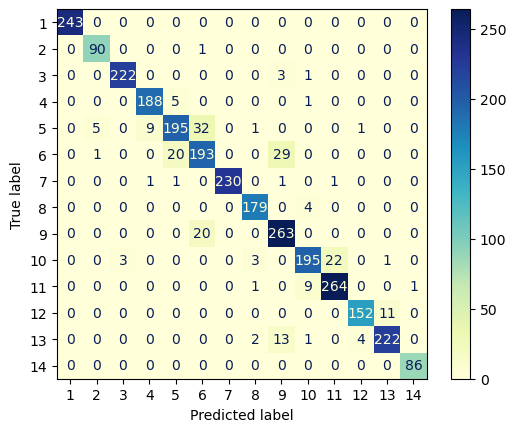

In [52]:
cmap_list = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', \
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',\
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=clf.classes_)
disp.plot(cmap=cmap_list[14])
plt.show()

In [53]:
print(f"\nResult of this Pipeline: {colored('Input_Data', 'blue')} ---> \
{colored('Standard Scaler', 'magenta')} ---> {colored('SVC(rbf)', 'magenta')}")
print(f'\nOverall Accuracy: {colored(ov_acc, "green")}\n\n\u03BA = {colored(kappa, "green")}\n')


Result of this Pipeline: Input_Data ---> Standard Scaler ---> SVC(rbf)

Overall Accuracy: 0.9290102389078498

κ = 0.923081359914085



$\newline$
$\newline$
- <a name=''>${\bf{\text{Classification Map for }\underline{\text{Test Data}}}}$</a>
$\newline$
$\newline$

In [57]:
print(f'\nShape of the y\u0302: {colored(y_pred.shape, "blue")}\n')


Shape of the ŷ: (2930,)



In [82]:
length = y_pred.shape[0]
m = int(length ** 0.5)
n = m
selected_y_pred = y_pred[: m*n]
selected_y_pred_reshaped = selected_y_pred.reshape((m, n))
selected_y_test = y_test[: m*n]
selected_y_test_reshaped = selected_y_test.reshape((m, n))

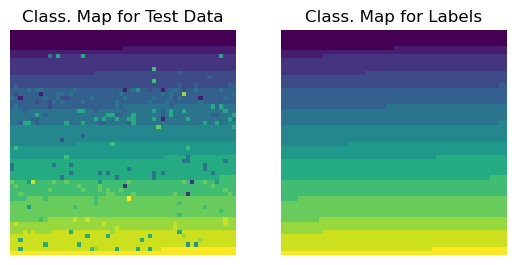

In [86]:
plt.figure(1)
plt.subplot(1, 2, 1), plt.imshow(selected_y_pred_reshaped), \
plt.axis('off'), plt.title('Class. Map for Test Data')

plt.subplot(1, 2, 2), plt.imshow(selected_y_test_reshaped), \
plt.axis('off'), plt.title('Class. Map for Labels')
plt.show()

In [92]:
my_ov_acc = len(y_pred[y_pred == y_test]) / len(y_pred)
print(f'\n{colored("Ov. Accuracy:", "green")} {my_ov_acc: 0.3f}\n')


Ov. Accuracy:  0.929



- <a name=''>${\bf{\text{SVC(poly)}}}$</a>

- - <a name=''>${\text{Grid Search}}$</a>

In [135]:
svc = SVC(kernel='poly', random_state=0)

In [136]:
pipe = Pipeline(steps=[("svc", svc)])

In [137]:
param_grid = {'svc__C': np.logspace(1, 2, 11), 'svc__degree': [2, 3, 4, 5], \
             'svc__gamma': np.linspace(0, 1, 11)}

In [138]:
input_data_dict = data_scaled

In [139]:
train_size = 0.1
X_train, y_train = input_data_dict['X_train_' + str(train_size)], input_data_dict['y_train_' + str(train_size)]
search = GridSearchCV(pipe, param_grid, cv=10)
search.fit(X_train, y_train)

/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
440 fits failed out of a total of 4840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
440 fits failed with the following error:
Traceback (most recent call last):
  File "/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/shahin/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in f

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('svc',
                                        SVC(kernel='poly', random_state=0))]),
             param_grid={'svc__C': array([ 10.        ,  12.58925412,  15.84893192,  19.95262315,
        25.11886432,  31.6227766 ,  39.81071706,  50.11872336,
        63.09573445,  79.43282347, 100.        ]),
                         'svc__degree': [2, 3, 4, 5],
                         'svc__gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [140]:
best_params = search.best_params_
best_lambda, best_gamma, best_degree = best_params['svc__C'], best_params['svc__gamma'], \
best_params['svc__degree']
print(f'\n\u03BB = {colored(best_lambda, "blue")}\n\n\u03B3 = {colored(best_gamma, "blue")}\n\nDegree = \
{colored(best_degree, "blue")}\n')


λ = 15.848931924611133

γ = 0.1

Degree = 3



In [141]:
best_score = search.best_score_
print(f'\nBest Accuracy is: {colored(best_score, "green")}\n')


Best Accuracy is: 0.8979166666666668



- - <a name=''>${\text{Test:}}$</a>

In [142]:
train_size = 0.1
clf = SVC(C=best_lambda, kernel='poly', degree=best_degree, gamma=best_gamma)
X_train, y_train, X_test, y_test = input_data_dict['X_train_' + str(train_size)], \
input_data_dict['y_train_' + str(train_size)], input_data_dict['X_test_' + str(train_size)], \
input_data_dict['y_test_' + str(train_size)]
clf.fit(X_train, y_train)

SVC(C=15.848931924611133, gamma=0.1, kernel='poly')

In [145]:
y_pred = clf.predict(X_test)
ov_acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
acc_for_each_class = conf_mat.diagonal()/conf_mat.sum(axis=1)
df_result1 = pd.DataFrame({'Class': range(1, 15), 'Accuracy': acc_for_each_class})
df_result1

,Class,Accuracy
0,1,1.000000
1,2,0.989011
2,3,0.878261
3,4,0.953846
4,5,0.841463
5,6,0.775000
6,7,0.970085
7,8,0.982353
8,9,0.799296
9,10,0.909091


- <a name=''>${\bf{\text{Heatmap of Confusion Matrix}}}$</a>

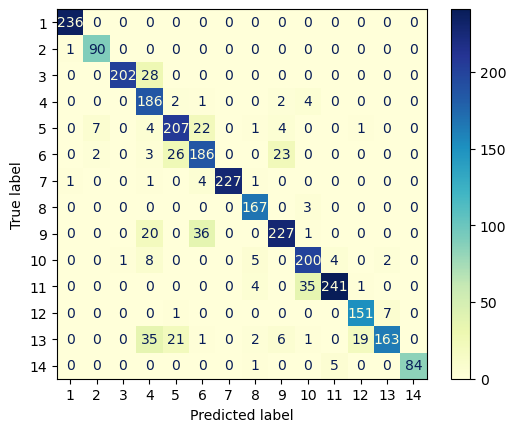

In [146]:
cmap_list = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', \
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',\
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=clf.classes_)
disp.plot(cmap=cmap_list[14])
plt.show()

In [147]:
print(f"\nResult of this Pipeline: {colored('Input_Data', 'blue')} ---> {colored('Standard Scaler', 'magenta')}\
 ---> {colored('SVC(poly)', 'magenta')}")
print(f'\nOverall Accuracy: {colored(ov_acc, "green")}\n\n\u03BA = {colored(kappa, "green")}\n')


Result of this Pipeline: Input_Data ---> Standard Scaler ---> SVC(poly)

Overall Accuracy: 0.877906976744186

κ = 0.867853468943284



$\newline$
$\newline$
- <a name=''>${\bf{\text{Classification Map for }\underline{\text{Test Data}}}}$</a>
$\newline$
$\newline$

In [ ]:
print(f'\nShape of the y\u0302: {colored(y_pred.shape, "blue")}\n')

In [ ]:
length = y_pred.shape[0]
m = int(length ** 0.5)
n = m
selected_y_pred = y_pred[: m*n]
selected_y_pred_reshaped = selected_y_pred.reshape((m, n))
selected_y_test = y_test[: m*n]
selected_y_test_reshaped = selected_y_test.reshape((m, n))

In [ ]:
plt.figure(1)
plt.subplot(1, 2, 1), plt.imshow(selected_y_pred_reshaped), \
plt.axis('off'), plt.title('Class. Map for Test Data')

plt.subplot(1, 2, 2), plt.imshow(selected_y_test_reshaped), \
plt.axis('off'), plt.title('Class. Map for Labels')
plt.show()

In [ ]:
my_ov_acc = len(y_pred[y_pred == y_test]) / len(y_pred)
print(f'\n{colored("Ov. Accuracy:", "green")} {my_ov_acc: 0.3f}\n')

- <a name=''>${\bf{\text{PCA + SVC}}}$</a>

In [148]:
input_data_dict = data_scaled

In [149]:
pca = PCA(n_components=4)

In [150]:
train_size_list = [0.1]
data_reduced = {}
print(f'\n                       For n_components = {colored(pca.n_components, "red")}\n\n')
for train_size in train_size_list:
    data_reduced['X_train_' + str(train_size)] = pca.fit_transform(input_data_dict['X_train_' + str(train_size)])
    print(f'\nExplained Variance for X_train_{colored(train_size, "green")}: \
    {colored(np.sum(pca.explained_variance_ratio_), "blue")}\n')
    
    data_reduced['X_test_' + str(train_size)] = pca.fit_transform(input_data_dict['X_test_' + str(train_size)])
    print(f'\nExplained Variance for X_test_{colored(train_size, "green")}: \
    {colored(np.sum(pca.explained_variance_ratio_), "blue")}\n')
    
    data_reduced['y_train_' + str(train_size)] = input_data_dict['y_train_' + str(train_size)]
    data_reduced['y_test_' + str(train_size)] = input_data_dict['y_test_' + str(train_size)]


                       For n_components = 4



Explained Variance for X_train_0.1:     0.9914875016565682


Explained Variance for X_test_0.1:     0.99155643087652



In [151]:
train_size = 0.1
print(f'\n\nMax of {colored("X_train_" + str(train_size), "green")}: \
{(data_reduced["X_train_" + str(train_size)]).max(): 0.3f}')
print(f'\nMin of {colored("X_train_" + str(train_size), "green")}: \
{(data_reduced["X_train_" + str(train_size)]).min(): 0.3f}')
print(f'\nMean of {colored("X_train_" + str(train_size), "green")}: \
{(data_reduced["X_train_" + str(train_size)]).mean(): 0.3f}')
print(f'\nVar of {colored("X_train_" + str(train_size), "green")}: \
{(data_reduced["X_train_" + str(train_size)]).var(): 0.3f}\n\n')



Max of X_train_0.1:  41.007

Min of X_train_0.1: -26.168

Mean of X_train_0.1: -0.000

Var of X_train_0.1:  35.941




In [152]:
standard_scaler = StandardScaler()

In [154]:
train_size_list = [0.1]
data_scaled = {}

for train_size in train_size_list:
    data_scaled['X_train_' + str(train_size)] = \
    standard_scaler.fit_transform(data_reduced['X_train_' + str(train_size)])
    data_scaled['X_test_' + str(train_size)] = \
    standard_scaler.fit_transform(data_reduced['X_test_' + str(train_size)])
    data_scaled['y_train_' + str(train_size)] = data_reduced['y_train_' + str(train_size)]
    data_scaled['y_test_' + str(train_size)] = data_reduced['y_test_' + str(train_size)]

In [156]:
train_size = 0.1
print(f'\n\nMax of {colored("X_train_" + str(train_size), "green")}: \
{(data_scaled["X_train_" + str(train_size)]).max(): 0.3f}')
print(f'\nMin of {colored("X_train_" + str(train_size), "green")}: \
{(data_scaled["X_train_" + str(train_size)]).min(): 0.3f}')
print(f'\nMean of {colored("X_train_" + str(train_size), "green")}: \
{(data_scaled["X_train_" + str(train_size)]).mean(): 0.3f}')
print(f'\nVar of {colored("X_train_" + str(train_size), "green")}: \
{(data_scaled["X_train_" + str(train_size)]).var(): 0.3f}\n\n')



Max of X_train_0.1:  8.306

Min of X_train_0.1: -2.443

Mean of X_train_0.1:  0.000

Var of X_train_0.1:  1.000




- - <a name=''>${\text{Grid Search}}$</a>

In [78]:
data_reduced = data_scaled
input_data_dict = data_reduced

In [79]:
svc = SVC(random_state=0)

In [80]:
pipe = Pipeline(steps=[("svc", svc)])

In [158]:
param_grid = {'svc__C': np.logspace(-4, 4, 9), 'svc__kernel': ['linear', 'poly', 'rbf'], \
             'svc__gamma': np.linspace(0, 1, 11), 'svc__degree': [2, 3, 4]}

In [159]:
train_size = 0.1
best_k_fold = 10
X_train, y_train = input_data_dict['X_train_' + str(train_size)], input_data_dict['y_train_' + str(train_size)]
search = GridSearchCV(pipe, param_grid, cv=best_k_fold)
search.fit(X_train, y_train)

/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
810 fits failed out of a total of 8910.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/shahin/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in f

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('svc',
                                        SVC(kernel='poly', random_state=0))]),
             param_grid={'svc__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'svc__degree': [2, 3, 4],
                         'svc__gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'svc__kernel': ['linear', 'poly', 'rbf']})

In [160]:
best_params = search.best_params_
best_lambda, best_gamma, best_kernel, best_degree = best_params['svc__C'], best_params['svc__gamma'], \
best_params['svc__kernel'], best_params['svc__degree']
print(f'\n\u03BB = {colored(best_lambda, "blue")}\n\n\u03B3 = \
{colored(best_gamma, "blue")}\n\nKernel = {colored(best_kernel, "blue")}\n\nDegree = \
{colored(best_degree, "blue")}\n')


λ = 1.0

γ = 0.1

Kernel = linear

Degree = 2



In [161]:
best_score = search.best_score_
print(f'\nBest Accuracy is: {colored(best_score, "green")}\n')


Best Accuracy is: 0.9385416666666668



- - <a name=''>${\text{Test:}}$</a>

In [162]:
train_size = 0.1
clf = SVC(C=best_lambda, kernel=best_kernel, degree=best_degree, gamma=best_gamma)
X_train, y_train, X_test, y_test = input_data_dict['X_train_' + str(train_size)], \
input_data_dict['y_train_' + str(train_size)], input_data_dict['X_test_' + str(train_size)], \
input_data_dict['y_test_' + str(train_size)]
clf.fit(X_train, y_train)

SVC(degree=2, gamma=0.1, kernel='linear')

In [163]:
y_pred = clf.predict(X_test)
ov_acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
acc_for_each_class = conf_mat.diagonal()/conf_mat.sum(axis=1)
df_result1 = pd.DataFrame({'Class': range(1, 15), 'Accuracy': acc_for_each_class})
df_result1

,Class,Accuracy
0,1,1.000000
1,2,1.000000
2,3,0.995652
3,4,0.917949
4,5,0.837398
5,6,0.841667
6,7,0.978632
7,8,0.994118
8,9,0.873239
9,10,0.945455


- <a name=''>${\bf{\text{Heatmap for Confusion Matrix}}}$</a>

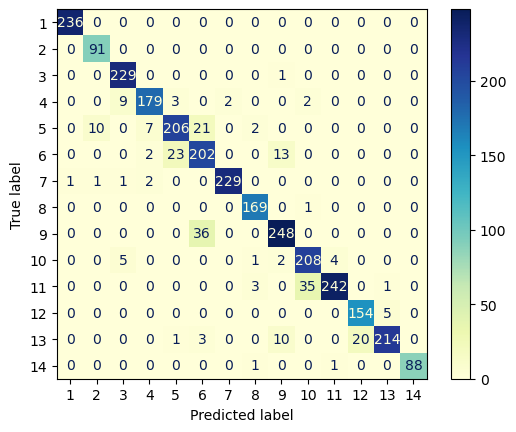

In [164]:
cmap_list = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', \
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',\
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=clf.classes_)
disp.plot(cmap=cmap_list[14])
plt.show()

In [165]:
print(f"\nResult of this Pipeline: {colored('Input_Data', 'blue')} ---> \
{colored('Standard Scaler', 'magenta')}\
 ---> PCA ---> {colored('Standard Scaler', 'magenta')} ---> {colored('SVC', 'magenta')}")
print(f'\nOverall Accuracy: {colored(ov_acc, "green")}\n\n\u03BA = {colored(kappa, "green")}\n')


Result of this Pipeline: Input_Data ---> Standard Scaler ---> PCA ---> Standard Scaler ---> SVC

Overall Accuracy: 0.9216826265389877

κ = 0.9151951858542293



$\newline$
$\newline$
- <a name=''>${\bf{\text{Classification Map for }\underline{\text{Test Data}}}}$</a>
$\newline$
$\newline$

In [ ]:
print(f'\nShape of the y\u0302: {colored(y_pred.shape, "blue")}\n')

In [ ]:
length = y_pred.shape[0]
m = int(length ** 0.5)
n = m
selected_y_pred = y_pred[: m*n]
selected_y_pred_reshaped = selected_y_pred.reshape((m, n))
selected_y_test = y_test[: m*n]
selected_y_test_reshaped = selected_y_test.reshape((m, n))

In [ ]:
plt.figure(1)
plt.subplot(1, 2, 1), plt.imshow(selected_y_pred_reshaped), \
plt.axis('off'), plt.title('Class. Map for Test Data')

plt.subplot(1, 2, 2), plt.imshow(selected_y_test_reshaped), \
plt.axis('off'), plt.title('Class. Map for Labels')
plt.show()

In [ ]:
my_ov_acc = len(y_pred[y_pred == y_test]) / len(y_pred)
print(f'\n{colored("Ov. Accuracy:", "green")} {my_ov_acc: 0.3f}\n')

- <a name='4'>${\bf{\text{2D SWT + 1D SWT + SVM}}}$</a>

In [15]:
import pywt

In [16]:
data = data_without_BG
data_gt = gt_without_BG
print(f'\nShape of Data: {colored(data.shape, "blue")}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(data.dtype, "green")}\n')
print(f'\n\nShape of GT: {colored(data_gt.shape, "blue")}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(data_gt.dtype, "green")}\n')


Shape of Data: (3248, 145)

 ... and its Data Type: uint16



Shape of GT: (3248,)

 ... and its Data Type: uint8



In [17]:
spatial_max_level = pywt.swt_max_level(data.shape[0])
print(f'\nMax level for spatial direction: {colored(spatial_max_level, "blue")}\n')


Max level for spatial direction: 4



In [18]:
data_swt_spatial_list = pywt.swtn(data, wavelet='db2', level=1, axes=(0, ))

In [19]:
def concat_for_swt(data_list: list, data_gt: np.ndarray, axis: int=0) -> (np.ndarray, np.ndarray):
    data_list_copy = data_list.copy()
    new_gt = data_gt.copy()
    for (i, data_dict) in enumerate(data_list_copy):
        if i == 0: 
            new_data = np.concatenate((data_dict['a'], data_dict['d']), axis=axis)
            if axis == 0:
                new_gt = np.concatenate((data_gt, data_gt))
        else: 
            new_data = np.concatenate((new_data, data_dict['a'], data_dict['d']), axis=axis)
            if axis == 0:
                new_gt = np.concatenate((new_gt, data_gt, data_gt))
            
    return new_data, new_gt

In [20]:
spatial_swt_data, spatial_swt_gt = concat_for_swt(data_swt_spatial_list, data_gt)

In [21]:
print(f'\nShape of {colored("Spatial SWT Data", "green")}: {colored(spatial_swt_data.shape, "blue")}\n')
print(f'Shape of {colored("Spatial SWT GT", "green")}: {colored(spatial_swt_gt.shape, "blue")}\n')


Shape of Spatial SWT Data: (6496, 145)

Shape of Spatial SWT GT: (6496,)



In [22]:
max_level = pywt.swt_max_level(spatial_swt_data.shape[1])
print(f'\nMax level for spectral direction: {colored(max_level, "blue")}\n')


Max level for spectral direction: 0



/tmp/ipykernel_14787/706708911.py:1: UserWarning: No levels of stationary wavelet decomposition are possible. The signal to be transformed must have a size that is a multiple of 2**n for an n-level decomposition.
  max_level = pywt.swt_max_level(spatial_swt_data.shape[1])


In [29]:
# new_feature = (spatial_swt_data[:, -1]).reshape((spatial_swt_data.shape[0], 1))

# if spatial_swt_data.shape[1]%2 == 0:
#     data_swt_spectral_list = pywt.swtn(spatial_swt_data, wavelet='db2', level=1, axes=(1, ))
    
# else:
#     spatial_swt_data = np.concatenate((spatial_swt_data, new_feature), axis=1)
#     data_swt_spectral_list = pywt.swtn(spatial_swt_data, wavelet='db2', level=1, axes=(1, ))

In [17]:
# spectral_swt_data, spectral_swt_gt = concat_for_swt(data_swt_spectral_list, spatial_swt_gt, axis=1)

In [23]:
# New: **************************************************************************
spectral_swt_data, spectral_swt_gt = spatial_swt_data, spatial_swt_gt

In [24]:
print(f'\nShape of {colored("Spectral SWT Data", "green")}: {colored(spectral_swt_data.shape, "blue")}\n')
print(f'Shape of {colored("Spectral SWT GT", "green")}: {colored(spectral_swt_gt.shape, "blue")}\n')


Shape of Spectral SWT Data: (6496, 145)

Shape of Spectral SWT GT: (6496,)



In [25]:
final_data = spectral_swt_data
data_gt = spectral_swt_gt

In [26]:
train_size_list = [0.1]
data = {}
for train_size_float in train_size_list: data['X_train_' + str(train_size_float)], \
    data['X_test_' + \
    str(train_size_float)], data['y_train_' + str(train_size_float)], \
    data['y_test_' + str(train_size_float)] =\
    train_test_split(final_data, data_gt, train_size=\
                     train_size_float, random_state=0)

In [27]:
train_size = 0.1
X_train, X_test, y_train, y_test = data['X_train_' + str(train_size)], \
data['X_test_' + str(train_size)], data['y_train_' + str(train_size)], data['y_test_' + str(train_size)]
print(f'\nShape of {colored("X_train", "green")}: {colored(X_train.shape, "blue")}')
print(f'Shape of {colored("y_train", "green")}: {colored(y_train.shape, "blue")}\n')
print(f'\nShape of {colored("X_test", "green")}: {colored(X_test.shape, "blue")}')
print(f'Shape of {colored("y_test", "green")}: {colored(y_test.shape, "blue")}\n')


Shape of X_train: (649, 145)
Shape of y_train: (649,)


Shape of X_test: (5847, 145)
Shape of y_test: (5847,)



In [28]:
scaler = StandardScaler()

In [29]:
train_size_list = [0.1]
data_scaled = {}

for train_size in train_size_list:
    data_scaled['X_train_' + str(train_size)] = scaler.fit_transform(data['X_train_' + str(train_size)])
    data_scaled['X_test_' + str(train_size)] = scaler.fit_transform(data['X_test_' + str(train_size)])
    data_scaled['y_train_' + str(train_size)] = data['y_train_' + str(train_size)]
    data_scaled['y_test_' + str(train_size)] = data['y_test_' + str(train_size)]

In [30]:
train_size = 0.1
X_train_normal = data_scaled['X_train_' + str(train_size)]
y_train_normal = data_scaled['y_train_' + str(train_size)]

X_test_normal = data_scaled['X_test_' + str(train_size)]
y_test_normal = data_scaled['y_test_' + str(train_size)]

In [31]:
print(f'\nMean of {colored("X_train_normal", "blue")}: {X_train_normal.mean(): 0.3f}')
print(f'Var of {colored("X_train_normal", "blue")}: {X_train_normal.var(): 0.3f}\n')
print(f' ... and its Data Type: {colored(X_train_normal.dtype, "green")}\n')
print(f'\n\nMean of {colored("X_test_normal", "blue")}: {X_test_normal.mean(): 0.3f}')
print(f'Var of {colored("X_test_normal", "blue")}: {X_test_normal.var(): 0.3f}\n')
print(f' ... and its Data Type: {colored(X_test_normal.dtype, "green")}\n')


Mean of X_train_normal:  0.000
Var of X_train_normal:  1.000

 ... and its Data Type: float64



Mean of X_test_normal: -0.000
Var of X_test_normal:  1.000

 ... and its Data Type: float64



In [188]:
train_size_tuple = (0.1, )
k_fold_tuple = range(2, 20)

parameters_for_k_fold_dict = {'train_size': train_size_tuple, 'k_fold': k_fold_tuple}
total_length = 1
for key_name_str in parameters_for_k_fold_dict.keys():
    total_length *= len(parameters_for_k_fold_dict[key_name_str])
    
    
train_size_stored_values = np.zeros(total_length)
acc_mean_stored_values = np.zeros(total_length)
k_fold_stored_values = np.zeros(total_length)


clf_without_pca = SVC()
count = 0
for train_size in parameters_for_k_fold_dict['train_size']:
    X_train, y_train = data_scaled['X_train_' + str(train_size)], \
    data_scaled['y_train_' + str(train_size)]
    clf_without_pca.fit(X_train, y_train)
    for k_fold in parameters_for_k_fold_dict['k_fold']:
        count += 1
        scores = cross_val_score(clf_without_pca, X_train, y_train, cv=k_fold)
        acc_mean = scores.mean()
        train_size_stored_values[count - 1] = train_size
        acc_mean_stored_values[count - 1] = acc_mean
        k_fold_stored_values[count - 1] = k_fold
        
df_for_k_fold = pd.DataFrame({'Train Size': train_size_stored_values, 'K-fold(CV)': k_fold_stored_values,\
'Mean of Accuracy': acc_mean_stored_values})

/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 18 members, which is less than n_splits=19.
  warnings.warn(


In [189]:
df_for_k_fold

,Train Size,K-fold(CV),Mean of Accuracy
0,0.1,2.0,0.388314
1,0.1,3.0,0.392914
2,0.1,4.0,0.394446
3,0.1,5.0,0.400632
4,0.1,6.0,0.395897
5,0.1,7.0,0.403677
6,0.1,8.0,0.403681
7,0.1,9.0,0.402144
8,0.1,10.0,0.397572
9,0.1,11.0,0.400616


In [190]:
df1 = df_for_k_fold[df_for_k_fold['Train Size'] == 0.1]
df1

,Train Size,K-fold(CV),Mean of Accuracy
0,0.1,2.0,0.388314
1,0.1,3.0,0.392914
2,0.1,4.0,0.394446
3,0.1,5.0,0.400632
4,0.1,6.0,0.395897
5,0.1,7.0,0.403677
6,0.1,8.0,0.403681
7,0.1,9.0,0.402144
8,0.1,10.0,0.397572
9,0.1,11.0,0.400616


In [191]:
df1_result = df1[df1['Mean of Accuracy'] == (df1['Mean of Accuracy']).max()]
df1_result

,Train Size,K-fold(CV),Mean of Accuracy
14,0.1,16.0,0.410061


- - <a name=''>${\text{Grid Search}}$</a>

In [32]:
svc = SVC(random_state=0)

In [33]:
pipe = Pipeline(steps=[("svc", svc)])

In [194]:
param_grid = {'svc__C': np.logspace(-4, 4, 9), 'svc__degree': [2, 3, 4], \
             'svc__gamma': np.linspace(0, 1, 11), 'svc__kernel': ['poly', 'rbf']}

In [34]:
input_data_dict = data_scaled

In [ ]:
best_k_fold = 16
train_size = 0.1
X_train, y_train = input_data_dict['X_train_' + str(train_size)], input_data_dict['y_train_' + str(train_size)]
search = GridSearchCV(pipe, param_grid, cv=best_k_fold)
search.fit(X_train, y_train)

In [34]:
best_params = search.best_params_
best_lambda, best_gamma, best_degree, best_kernel = best_params['svc__C'], best_params['svc__gamma'], \
best_params['svc__degree'], best_params['svc__kernel']
print(f'\n\u03BB = {colored(best_lambda, "blue")}\n\n\u03B3 = {colored(best_gamma, "blue")}\
\n\nbest Kernel: {colored(best_kernel, "blue")}\n\nDegree = \
{colored(best_degree, "blue")}\n')


λ = 0.0001

γ = 0.5

best Kernel: poly

Degree = 2



In [35]:
best_score = search.best_score_
print(f'\nBest Accuracy is: {colored(best_score, "green")}\n')


Best Accuracy is: 0.43025914634146345



- - <a name=''>${\text{Test}}$</a>

In [35]:
best_lambda, best_kernel, best_degree, best_gamma = 1e-4, 'poly', 2, 0.5

In [36]:
train_size = 0.1
clf = SVC(C=best_lambda, kernel=best_kernel, degree=best_degree, gamma=best_gamma)
X_train, y_train, X_test, y_test = input_data_dict['X_train_' + str(train_size)], \
input_data_dict['y_train_' + str(train_size)], input_data_dict['X_test_' + str(train_size)], \
input_data_dict['y_test_' + str(train_size)]
clf.fit(X_train, y_train)

SVC(C=0.0001, degree=2, gamma=0.5, kernel='poly')

In [37]:
y_pred = clf.predict(X_test)
ov_acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
acc_for_each_class = conf_mat.diagonal()/conf_mat.sum(axis=1)
df_result1 = pd.DataFrame({'Class': range(1, 15), 'Accuracy': acc_for_each_class})
df_result1

,Class,Accuracy
0,1,0.516529
1,2,0.000000
2,3,0.958904
3,4,0.000000
4,5,0.463830
5,6,0.373967
6,7,0.215481
7,8,0.109290
8,9,0.000000
9,10,0.330357


- <a name=''>${\bf{\text{Heatmap for Confusion Matrix}}}$</a>

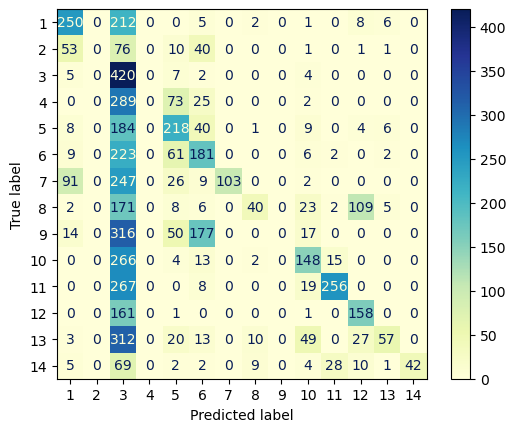

In [38]:
cmap_list = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', \
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',\
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=clf.classes_)
disp.plot(cmap=cmap_list[14])
plt.show()

In [39]:
print(f"\nResult of this Pipeline: {colored('Input_Data', 'blue')} ---> \
{colored('2D SWT + 1D SWT', 'green')} ---> {colored('Standard Scaler', 'magenta')} \
--->  {colored('SVC', 'magenta')}")
print(f'\nOverall Accuracy: {colored(ov_acc, "green")}\n\n\u03BA = {colored(kappa, "green")}\n')


Result of this Pipeline: Input_Data ---> 2D SWT + 1D SWT ---> Standard Scaler --->  SVC

Overall Accuracy: 0.3203352146399863

κ = 0.26409449142090957



- <a name='3'>${\bf{\text{PCA + 2D SWT + 1D SWT + SVM}}}$</a>

In [40]:
import pywt

In [41]:
data = data_without_BG
data_gt = gt_without_BG
print(f'\nShape of Data: {colored(data.shape, "blue")}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(data.dtype, "green")}\n')
print(f'\n\nShape of GT: {colored(data_gt.shape, "blue")}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(data_gt.dtype, "green")}\n')


Shape of Data: (3248, 145)

 ... and its Data Type: uint16



Shape of GT: (3248,)

 ... and its Data Type: uint8



- - <a name=''>${\text{PCA}}$</a>

In [42]:
input_data_dict = data_scaled

In [59]:
pca = PCA(n_components=3)

In [60]:
train_size_list = [0.1]
data_reduced = {}
print(f'\n                       For n_components = {colored(pca.n_components, "red")}\n\n')
for train_size in train_size_list:
    data_reduced['X_train_' + str(train_size)] = pca.fit_transform(input_data_dict['X_train_' + str(train_size)])
    print(f'\nExplained Variance for X_train_{colored(train_size, "green")}: \
    {colored(np.sum(pca.explained_variance_ratio_), "blue")}\n')
    
    data_reduced['X_test_' + str(train_size)] = pca.fit_transform(input_data_dict['X_test_' + str(train_size)])
    print(f'\nExplained Variance for X_test_{colored(train_size, "green")}: \
    {colored(np.sum(pca.explained_variance_ratio_), "blue")}\n')
    
    data_reduced['y_train_' + str(train_size)] = input_data_dict['y_train_' + str(train_size)]
    data_reduced['y_test_' + str(train_size)] = input_data_dict['y_test_' + str(train_size)]


                       For n_components = 3



Explained Variance for X_train_0.1:     0.9960162147613599


Explained Variance for X_test_0.1:     0.996000328680024



In [61]:
train_size = 0.1
print(f'\n\nMax of {colored("X_train_" + str(train_size), "green")}: \
{(data_reduced["X_train_" + str(train_size)]).max(): 0.3f}')
print(f'\nMin of {colored("X_train_" + str(train_size), "green")}: \
{(data_reduced["X_train_" + str(train_size)]).min(): 0.3f}')
print(f'\nMean of {colored("X_train_" + str(train_size), "green")}: \
{(data_reduced["X_train_" + str(train_size)]).mean(): 0.3f}')
print(f'\nVar of {colored("X_train_" + str(train_size), "green")}: \
{(data_reduced["X_train_" + str(train_size)]).var(): 0.3f}\n\n')



Max of X_train_0.1:  36.457

Min of X_train_0.1: -16.535

Mean of X_train_0.1: -0.000

Var of X_train_0.1:  48.141




In [62]:
standard_scaler = StandardScaler()

In [63]:
train_size_list = [0.1]
data_scaled = {}

for train_size in train_size_list:
    data_scaled['X_train_' + str(train_size)] = \
    standard_scaler.fit_transform(data_reduced['X_train_' + str(train_size)])
    data_scaled['X_test_' + str(train_size)] = \
    standard_scaler.fit_transform(data_reduced['X_test_' + str(train_size)])
    data_scaled['y_train_' + str(train_size)] = data_reduced['y_train_' + str(train_size)]
    data_scaled['y_test_' + str(train_size)] = data_reduced['y_test_' + str(train_size)]

In [64]:
train_size = 0.1
print(f'\n\nMax of {colored("X_train_" + str(train_size), "green")}: \
{(data_scaled["X_train_" + str(train_size)]).max(): 0.3f}')
print(f'\nMin of {colored("X_train_" + str(train_size), "green")}: \
{(data_scaled["X_train_" + str(train_size)]).min(): 0.3f}')
print(f'\nMean of {colored("X_train_" + str(train_size), "green")}: \
{(data_scaled["X_train_" + str(train_size)]).mean(): 0.3f}')
print(f'\nVar of {colored("X_train_" + str(train_size), "green")}: \
{(data_scaled["X_train_" + str(train_size)]).var(): 0.3f}\n\n')



Max of X_train_0.1:  4.364

Min of X_train_0.1: -2.943

Mean of X_train_0.1:  0.000

Var of X_train_0.1:  1.000




- - <a name=''>${\text{K-fold}}$</a>

In [66]:
train_size_tuple = (0.1, )
k_fold_tuple = range(2, 20)

parameters_for_k_fold_dict = {'train_size': train_size_tuple, 'k_fold': k_fold_tuple}
total_length = 1
for key_name_str in parameters_for_k_fold_dict.keys():
    total_length *= len(parameters_for_k_fold_dict[key_name_str])
    
    
train_size_stored_values = np.zeros(total_length)
acc_mean_stored_values = np.zeros(total_length)
k_fold_stored_values = np.zeros(total_length)


clf_without_pca = SVC()
count = 0
for train_size in parameters_for_k_fold_dict['train_size']:
    X_train, y_train = data_scaled['X_train_' + str(train_size)], \
    data_scaled['y_train_' + str(train_size)]
    clf_without_pca.fit(X_train, y_train)
    for k_fold in parameters_for_k_fold_dict['k_fold']:
        count += 1
        scores = cross_val_score(clf_without_pca, X_train, y_train, cv=k_fold)
        acc_mean = scores.mean()
        train_size_stored_values[count - 1] = train_size
        acc_mean_stored_values[count - 1] = acc_mean
        k_fold_stored_values[count - 1] = k_fold
        
df_for_k_fold = pd.DataFrame({'Train Size': train_size_stored_values, 'K-fold(CV)': k_fold_stored_values,\
'Mean of Accuracy': acc_mean_stored_values})

/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 18 members, which is less than n_splits=19.
  warnings.warn(


In [67]:
df_for_k_fold

,Train Size,K-fold(CV),Mean of Accuracy
0,0.1,2.0,0.326662
1,0.1,3.0,0.323498
2,0.1,4.0,0.335852
3,0.1,5.0,0.340501
4,0.1,6.0,0.354329
5,0.1,7.0,0.345121
6,0.1,8.0,0.338998
7,0.1,9.0,0.363711
8,0.1,10.0,0.357476
9,0.1,11.0,0.354391


In [68]:
df1 = df_for_k_fold[df_for_k_fold['Train Size'] == 0.1]
df1

,Train Size,K-fold(CV),Mean of Accuracy
0,0.1,2.0,0.326662
1,0.1,3.0,0.323498
2,0.1,4.0,0.335852
3,0.1,5.0,0.340501
4,0.1,6.0,0.354329
5,0.1,7.0,0.345121
6,0.1,8.0,0.338998
7,0.1,9.0,0.363711
8,0.1,10.0,0.357476
9,0.1,11.0,0.354391


In [69]:
df1_result = df1[df1['Mean of Accuracy'] == (df1['Mean of Accuracy']).max()]
df1_result

,Train Size,K-fold(CV),Mean of Accuracy
12,0.1,14.0,0.368211


- - <a name=''>${\text{Grid Search}}$</a>

In [65]:
svc = SVC(random_state=0)

In [66]:
pipe = Pipeline(steps=[("svc", svc)])

In [67]:
param_grid = {'svc__C': np.logspace(-4, 4, 9), 'svc__degree': [2, 3, 4], \
             'svc__gamma': np.linspace(0, 1, 11), 'svc__kernel': ['linear', 'poly', 'rbf']}

In [68]:
input_data_dict = data_scaled

In [11]:
best_k_fold = 14
train_size = 0.1
X_train, y_train = input_data_dict['X_train_' + str(train_size)], input_data_dict['y_train_' + str(train_size)]
search = GridSearchCV(pipe, param_grid, cv=best_k_fold)
search.fit(X_train, y_train)

NameError: name 'input_data_dict' is not defined

In [ ]:
best_params = search.best_params_
best_lambda, best_gamma, best_degree, best_kernel = best_params['svc__C'], best_params['svc__gamma'], \
best_params['svc__degree'], best_params['svc__kernel']
print(f'\n\u03BB = {colored(best_lambda, "blue")}\n\n\u03B3 = {colored(best_gamma, "blue")}\
\n\nbest Kernel: {colored(best_kernel, "blue")}\n\nDegree = \
{colored(best_degree, "blue")}\n')

In [ ]:
best_score = search.best_score_
print(f'\nBest Accuracy is: {colored(best_score, "green")}\n')

- - <a name=''>${\text{Test}}$</a>

In [ ]:
train_size = 0.1
clf = SVC(C=best_lambda, kernel=best_kernel, degree=best_degree, gamma=best_gamma)
X_train, y_train, X_test, y_test = input_data_dict['X_train_' + str(train_size)], \
input_data_dict['y_train_' + str(train_size)], input_data_dict['X_test_' + str(train_size)], \
input_data_dict['y_test_' + str(train_size)]
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
ov_acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
acc_for_each_class = conf_mat.diagonal()/conf_mat.sum(axis=1)
df_result1 = pd.DataFrame({'Class': range(1, 15), 'Accuracy': acc_for_each_class})
df_result1

In [ ]:
print(f"\nResult of this Pipeline: {colored('Input_Data', 'blue')} ---> PCA ---> \
{colored('2D SWT + 1D SWT', 'green')} ---> {colored('Standard Scaler', 'magenta')} \
--->  {colored('SVC', 'magenta')}")
print(f'\nOverall Accuracy: {colored(ov_acc, "green")}\n\n\u03BA = {colored(kappa, "green")}\n')

$\newline$
<a name=''>${\bf{\text{Creating Noisy Data}}}$</a>
$\newline$

In [12]:
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

In [13]:
def min_max_scaler(input_img: np.ndarray, data_range: tuple=(0, 1)) -> np.ndarray:
    img = input_img.copy()
    a, b = data_range[0], data_range[1]
    img = (img - img.min()) / (img.max() - img.min())
    img *= (b - a)
    img += a
    return img

In [14]:
data = pymat.read_mat(path_str + data_file_name)['Botswana']
data_gt = pymat.read_mat(path_str + gt_file_name)['Botswana_gt']

In [15]:
data_without_BG, gt_without_BG = BG_removal(data_3D=data, data_gt_2D=data_gt)

In [16]:
print(f'\nShape of BG_removed Data: {colored(data_without_BG.shape, "blue")}\n')
print(f' ... and its Data Type: {colored(data_without_BG.dtype, "blue")}\n')
print(f'\nShape of BG_removed GT: {colored(gt_without_BG.shape, "blue")}\n')
print(f' ... and its Data Type: {colored(gt_without_BG.dtype, "blue")}\n')


Shape of BG_removed Data: (3248, 145)

 ... and its Data Type: uint16


Shape of BG_removed GT: (3248,)

 ... and its Data Type: uint8



In [17]:
# scaler = MinMaxScaler()
# data_scaled, gt_scaled = min_max_scaler(data_without_BG), gt_without_BG
# data_scaled, gt_scaled = scaler.fit_transform(data_without_BG), gt_without_BG

scaler = min_max_scaler
data_scaled, gt_scaled = scaler(data_without_BG), gt_without_BG

In [18]:
print(f'\nShape of Scaled Data: {colored(data_scaled.shape, "blue")}\n')
print(f' ... and its Data Type: {colored(data_scaled.dtype, "blue")}\n')
print(f'\nShape of Scaled GT: {colored(gt_scaled.shape, "blue")}\n')
print(f' ... and its Data Type: {colored(gt_scaled.dtype, "blue")}\n')


Shape of Scaled Data: (3248, 145)

 ... and its Data Type: float64


Shape of Scaled GT: (3248,)

 ... and its Data Type: uint8



- <a name=''>${\bf{\text{Gaussian Noise:}}}$</a>

In [19]:
mu = 0
sigma_2 = 0.0001
data_gaussian_noisy, gt_gaussian_noisy = random_noise(image=data_scaled, mode='gaussian', \
                                                      seed=0, var=sigma_2, mean=mu), gt_scaled
print(f'\nShape of the Gaussian Noisy Data: {colored(data_gaussian_noisy.shape, "blue")}')
print(f'\n ... and its Data Type: {colored(data_gaussian_noisy.dtype, "blue")}\n')


Shape of the Gaussian Noisy Data: (3248, 145)

 ... and its Data Type: float64



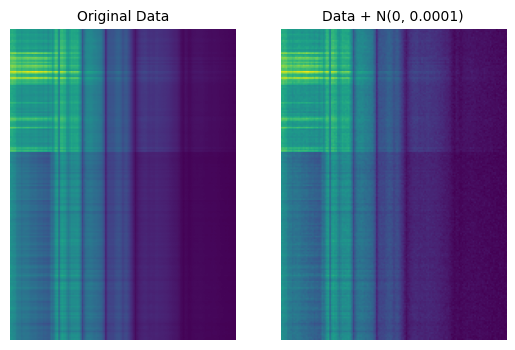

In [20]:
plt.figure(1, )
plt.subplot(1, 2, 1), plt.imshow(data_scaled[:200]), plt.axis('off'), \
plt.title('Original Data', fontsize=10)
plt.subplot(1, 2, 2, ), plt.imshow(data_gaussian_noisy[:200]), plt.axis('off'), \
plt.title(f'Data + N({mu}, {sigma_2})', fontsize=10)
plt.show()

- <a name=''>${\bf{\text{Data Splitting}}}$</a>

In [21]:
train_size_list = [0.1]
data = {}
for train_size_float in train_size_list: data['X_train_' + str(train_size_float)], \
    data['X_test_' + \
    str(train_size_float)], data['y_train_' + str(train_size_float)], \
    data['y_test_' + str(train_size_float)] =\
    train_test_split(data_gaussian_noisy, gt_gaussian_noisy, train_size=train_size_float, \
                    shuffle=True, random_state=0)

In [22]:
train_size = 0.1
X_train, X_test, y_train, y_test = data['X_train_' + str(train_size)], data['X_test_' + str(train_size)], \
data['y_train_' + str(train_size)], data['y_test_' + str(train_size)]

In [23]:
print(f'\nShape of the {colored("X_train", "green")}: {colored(X_train.shape, "blue")}\n')
print(f'Shape of the {colored("y_train", "green")}: {colored(y_train.shape, "blue")}\n\n')
print(f'\nShape of the {colored("X_test", "green")}: {colored(X_test.shape, "blue")}\n')
print(f'Shape of the {colored("y_test", "green")}: {colored(y_test.shape, "blue")}\n')


Shape of the X_train: (324, 145)

Shape of the y_train: (324,)



Shape of the X_test: (2924, 145)

Shape of the y_test: (2924,)



- <a name=''>${\bf{\text{Standard Scaling}}}$</a>

In [24]:
standard_scaler = StandardScaler()

In [25]:
train_size_list = [0.1]
data_scaled = {}

for train_size in train_size_list:
    data_scaled['X_train_' + str(train_size)] = \
    standard_scaler.fit_transform(data['X_train_' + str(train_size)])
    data_scaled['X_test_' + str(train_size)] = standard_scaler.fit_transform(data['X_test_' + str(train_size)])
    data_scaled['y_train_' + str(train_size)] = data['y_train_' + str(train_size)]
    data_scaled['y_test_' + str(train_size)] = data['y_test_' + str(train_size)]

In [26]:
train_size = 0.1
X_train, X_test, y_train, y_test = data_scaled['X_train_' + str(train_size)], \
data_scaled['X_test_' + str(train_size)], data_scaled['y_train_' + str(train_size)], \
data_scaled['y_test_' + str(train_size)]

In [27]:
print(f'\nMean of {colored("X_train", "green")}: {X_train.mean(): 0.3f}')
print(f'\nVar of {colored("X_train", "green")}: {X_train.var(): 0.3f}\n')
print(f' ... and its {colored("Data Type", "green")}: {X_train.dtype}\n')
print(f'\n\n\nMean of {colored("X_test", "green")}: {X_test.mean(): 0.3f}')
print(f'\nVar of {colored("X_test", "green")}: {X_test.var(): 0.3f}\n')
print(f' ... and its {colored("Data Type", "green")}: {X_test.dtype}\n')


Mean of X_train:  0.000

Var of X_train:  1.000

 ... and its Data Type: float64




Mean of X_test:  0.000

Var of X_test:  1.000

 ... and its Data Type: float64



- <a name=''>${\bf{\text{K-fold}}}$</a>

In [64]:
train_size_tuple = (0.1, )
k_fold_tuple = range(2, 16)

parameters_for_k_fold_dict = {'train_size': train_size_tuple, 'k_fold': k_fold_tuple}
total_length = 1
for key_name_str in parameters_for_k_fold_dict.keys():
    total_length *= len(parameters_for_k_fold_dict[key_name_str])
    
    
train_size_stored_values = np.zeros(total_length)
acc_mean_stored_values = np.zeros(total_length)
k_fold_stored_values = np.zeros(total_length)


clf_without_pca = SVC()
count = 0
for train_size in parameters_for_k_fold_dict['train_size']:
    X_train, y_train, X_test, y_test = data_scaled['X_train_' + str(train_size)], \
    data_scaled['y_train_' + str(train_size)], data_scaled['X_test_' + str(train_size)], \
    data_scaled['y_test_' + str(train_size)]
    clf_without_pca.fit(X_train, y_train)
    for k_fold in parameters_for_k_fold_dict['k_fold']:
        count += 1
        scores = cross_val_score(clf_without_pca, X_train, y_train, cv=k_fold)
        acc_mean = scores.mean()
        train_size_stored_values[count - 1] = train_size
        acc_mean_stored_values[count - 1] = acc_mean
        k_fold_stored_values[count - 1] = k_fold
        
df_for_k_fold = pd.DataFrame({'Train Size': train_size_stored_values, 'K-fold(CV)': k_fold_stored_values,\
'Mean of Accuracy': acc_mean_stored_values})

/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=7.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=9.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(

In [65]:
df_for_k_fold

,Train Size,K-fold(CV),Mean of Accuracy
0,0.1,2.0,0.651235
1,0.1,3.0,0.706790
2,0.1,4.0,0.765432
3,0.1,5.0,0.750000
4,0.1,6.0,0.759259
5,0.1,7.0,0.750429
6,0.1,8.0,0.772027
7,0.1,9.0,0.756173
8,0.1,10.0,0.768655
9,0.1,11.0,0.771787


In [66]:
df1 = df_for_k_fold[df_for_k_fold['Train Size'] == 0.1]
df1

,Train Size,K-fold(CV),Mean of Accuracy
0,0.1,2.0,0.651235
1,0.1,3.0,0.706790
2,0.1,4.0,0.765432
3,0.1,5.0,0.750000
4,0.1,6.0,0.759259
5,0.1,7.0,0.750429
6,0.1,8.0,0.772027
7,0.1,9.0,0.756173
8,0.1,10.0,0.768655
9,0.1,11.0,0.771787


In [67]:
df1_result = df1[df1['Mean of Accuracy'] == (df1['Mean of Accuracy']).max()]
df1_result

,Train Size,K-fold(CV),Mean of Accuracy
13,0.1,15.0,0.784416


- <a name=''>${\bf{\text{SVC(rbf)}}}$</a>

- - <a name=''>${{\text{Grid Search}}}$</a>

In [68]:
svc = SVC(kernel='rbf', random_state=0)

In [69]:
pipe = Pipeline(steps=[("svc", svc)])

In [70]:
param_grid = {'svc__C': np.logspace(-4, 4, 9), \
             'svc__gamma': np.linspace(0, 1, 11)}

In [71]:
input_data_dict = data_scaled

In [72]:
train_size = 0.1
best_k_fold = 15
X_train, y_train = input_data_dict['X_train_' + str(train_size)], input_data_dict['y_train_' + str(train_size)]
search = GridSearchCV(pipe, param_grid, cv=best_k_fold)
search.fit(X_train, y_train)

/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=15.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
135 fits failed out of a total of 1485.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/shahin/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in f

GridSearchCV(cv=15, estimator=Pipeline(steps=[('svc', SVC(random_state=0))]),
             param_grid={'svc__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'svc__gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [73]:
best_params = search.best_params_
best_lambda, best_gamma = best_params['svc__C'], best_params['svc__gamma']
print(f'\n\u03BB = {colored(best_lambda, "blue")}\n\n\u03B3 = {colored(best_gamma, "blue")}\n')


λ = 10.0

γ = 0.1



In [74]:
best_score = search.best_score_
print(f'\nBest Accuracy is: {colored(best_score, "blue")}\n')


Best Accuracy is: 0.27460317460317457



- - <a name=''>${\text{Test:}}$</a>

In [75]:
train_size = 0.1
clf = SVC(C=best_lambda, kernel='rbf', gamma=best_gamma)
X_train, y_train, X_test, y_test = input_data_dict['X_train_' + str(train_size)], \
input_data_dict['y_train_' + str(train_size)], input_data_dict['X_test_' + str(train_size)], \
input_data_dict['y_test_' + str(train_size)]
clf.fit(X_train, y_train)

SVC(C=10.0, gamma=0.1)

In [76]:
y_pred = clf.predict(X_test)
ov_acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
acc_for_each_class = conf_mat.diagonal()/conf_mat.sum(axis=1)
df_result1 = pd.DataFrame({'Class': range(1, 15), 'Accuracy': acc_for_each_class})
df_result1

,Class,Accuracy
0,1,0.906780
1,2,0.000000
2,3,0.008696
3,4,0.000000
4,5,0.024390
5,6,0.475000
6,7,0.000000
7,8,1.000000
8,9,0.647887
9,10,0.168182


- <a name=''>${\bf{\text{Heatmap for Confusion Matrix}}}$</a>

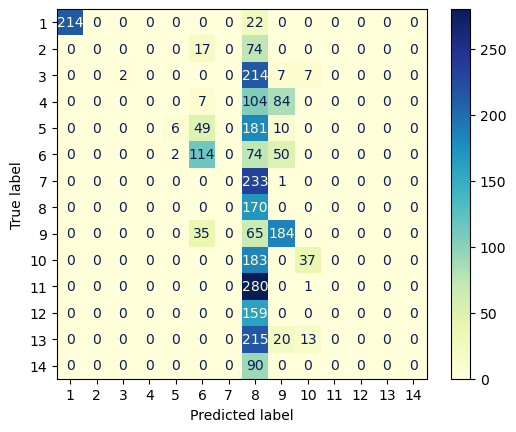

In [77]:
cmap_list = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', \
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',\
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=clf.classes_)
disp.plot(cmap=cmap_list[14])
plt.show()

In [78]:
print(f"\nResult of this Pipeline: {colored('Gaussian Noisy Input_Data', 'blue')} ---> \
{colored('Standard Scaler', 'magenta')} ---> {colored('SVC(rbf)', 'magenta')}")
print(f'\nOverall Accuracy: {colored(ov_acc, "green")}\n\n\u03BA = {colored(kappa, "green")}\n')


Result of this Pipeline: Gaussian Noisy Input_Data ---> Standard Scaler ---> SVC(rbf)

Overall Accuracy: 0.24863201094391243

κ = 0.19486490483555208



- <a name=''>${\bf{\text{SVC(poly)}}}$</a>

- - <a name=''>${{\text{Grid Search}}}$</a>

In [79]:
svc = SVC(kernel='poly', random_state=0)

In [80]:
pipe = Pipeline(steps=[("svc", svc)])

In [81]:
param_grid = {'svc__C': np.logspace(-4, 4, 9), \
             'svc__gamma': np.linspace(0, 1, 11), 'svc__degree': [2, 3, 4, 5]}

In [82]:
input_data_dict = data_scaled

In [83]:
train_size = 0.1
best_k_fold = 15
X_train, y_train = input_data_dict['X_train_' + str(train_size)], input_data_dict['y_train_' + str(train_size)]
search = GridSearchCV(pipe, param_grid, cv=best_k_fold)
search.fit(X_train, y_train)

/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=15.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
540 fits failed out of a total of 5940.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/shahin/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in f

GridSearchCV(cv=15,
             estimator=Pipeline(steps=[('svc',
                                        SVC(kernel='poly', random_state=0))]),
             param_grid={'svc__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'svc__degree': [2, 3, 4, 5],
                         'svc__gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [84]:
best_params = search.best_params_
best_lambda, best_gamma, best_degree = best_params['svc__C'], best_params['svc__gamma'], \
best_params['svc__degree']
print(f'\n\u03BB = {colored(best_lambda, "blue")}\n\n\u03B3 = \
{colored(best_gamma, "blue")}\n\nDegree: {colored(best_degree, "blue")}\n')


λ = 0.001

γ = 0.5

Degree: 3



In [85]:
best_score = search.best_score_
print(f'\nBest Accuracy is: {colored(best_score, "blue")}\n')


Best Accuracy is: 0.7243867243867242



- - <a name=''>${\text{Test:}}$</a>

In [86]:
train_size = 0.1
clf = SVC(C=best_lambda, kernel='poly', gamma=best_gamma, degree=best_degree)
X_train, y_train, X_test, y_test = input_data_dict['X_train_' + str(train_size)], \
input_data_dict['y_train_' + str(train_size)], input_data_dict['X_test_' + str(train_size)], \
input_data_dict['y_test_' + str(train_size)]
clf.fit(X_train, y_train)

SVC(C=0.001, gamma=0.5, kernel='poly')

In [87]:
y_pred = clf.predict(X_test)
ov_acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
acc_for_each_class = conf_mat.diagonal()/conf_mat.sum(axis=1)
df_result1 = pd.DataFrame({'Class': range(1, 15), 'Accuracy': acc_for_each_class})
df_result1

,Class,Accuracy
0,1,1.000000
1,2,0.802198
2,3,0.965217
3,4,0.825641
4,5,0.536585
5,6,0.554167
6,7,0.816239
7,8,0.817647
8,9,0.559859
9,10,0.490909


- <a name=''>${\bf{\text{Heatmap for Confusion Matrix}}}$</a>

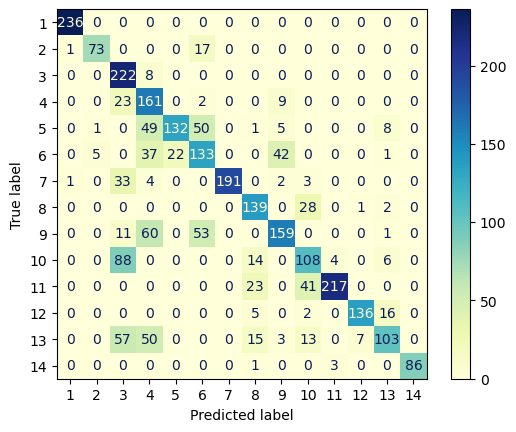

In [88]:
cmap_list = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', \
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',\
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=clf.classes_)
disp.plot(cmap=cmap_list[14])
plt.show()

In [89]:
print(f"\nResult of this Pipeline: {colored('Gaussian Noisy Input Data', 'blue')} ---> \
{colored('Standard Scaler', 'magenta')} ---> {colored('SVC(poly)', 'magenta')}")
print(f'\nOverall Accuracy: {colored(ov_acc, "green")}\n\n\u03BA = {colored(kappa, "green")}\n')


Result of this Pipeline: Gaussian Noisy Input Data ---> Standard Scaler ---> SVC(poly)

Overall Accuracy: 0.7168262653898769

κ = 0.6937007465585057



- <a name=''>${\bf{\text{PCA + SVM}}}$</a>

In [29]:
pca = PCA(n_components=2)

In [30]:
input_data_dict = data_scaled

In [31]:
train_size_list = [0.1]
data_reduced = {}
print(f'\n                       For n_components = {colored(pca.n_components, "red")}\n\n')
for train_size in train_size_list:
    data_reduced['X_train_' + str(train_size)] = pca.fit_transform(input_data_dict['X_train_' + str(train_size)])
    print(f'\nExplained Variance for X_train_{colored(train_size, "green")}: \
    {colored(np.sum(pca.explained_variance_ratio_), "blue")}\n')
    
    data_reduced['X_test_' + str(train_size)] = pca.fit_transform(input_data_dict['X_test_' + str(train_size)])
    print(f'\nExplained Variance for X_test_{colored(train_size, "green")}: \
    {colored(np.sum(pca.explained_variance_ratio_), "blue")}\n')
    
    data_reduced['y_train_' + str(train_size)] = input_data_dict['y_train_' + str(train_size)]
    data_reduced['y_test_' + str(train_size)] = input_data_dict['y_test_' + str(train_size)]


                       For n_components = 2



Explained Variance for X_train_0.1:     0.796030866207132


Explained Variance for X_test_0.1:     0.7971870234299268



In [32]:
train_size = 0.1
print(f'\n\nMax of {colored("X_train_" + str(train_size), "green")}: \
{(data_reduced["X_train_" + str(train_size)]).max(): 0.3f}')
print(f'\nMin of {colored("X_train_" + str(train_size), "green")}: \
{(data_reduced["X_train_" + str(train_size)]).min(): 0.3f}')
print(f'\nMean of {colored("X_train_" + str(train_size), "green")}: \
{(data_reduced["X_train_" + str(train_size)]).mean(): 0.3f}')
print(f'\nVar of {colored("X_train_" + str(train_size), "green")}: \
{(data_reduced["X_train_" + str(train_size)]).var(): 0.3f}\n\n')



Max of X_train_0.1:  36.997

Min of X_train_0.1: -24.020

Mean of X_train_0.1: -0.000

Var of X_train_0.1:  57.712




In [33]:
standard_scaler = StandardScaler()

In [34]:
train_size_list = [0.1]
data_scaled = {}

for train_size in train_size_list:
    data_scaled['X_train_' + str(train_size)] = \
    standard_scaler.fit_transform(data_reduced['X_train_' + str(train_size)])
    data_scaled['X_test_' + str(train_size)] = \
    standard_scaler.fit_transform(data_reduced['X_test_' + str(train_size)])
    data_scaled['y_train_' + str(train_size)] = data_reduced['y_train_' + str(train_size)]
    data_scaled['y_test_' + str(train_size)] = data_reduced['y_test_' + str(train_size)]

In [35]:
train_size = 0.1
print(f'\n\nMax of {colored("X_train_" + str(train_size), "green")}: \
{(data_scaled["X_train_" + str(train_size)]).max(): 0.3f}')
print(f'\nMin of {colored("X_train_" + str(train_size), "green")}: \
{(data_scaled["X_train_" + str(train_size)]).min(): 0.3f}')
print(f'\nMean of {colored("X_train_" + str(train_size), "green")}: \
{(data_scaled["X_train_" + str(train_size)]).mean(): 0.3f}')
print(f'\nVar of {colored("X_train_" + str(train_size), "green")}: \
{(data_scaled["X_train_" + str(train_size)]).var(): 0.3f}\n\n')



Max of X_train_0.1:  3.596

Min of X_train_0.1: -2.335

Mean of X_train_0.1:  0.000

Var of X_train_0.1:  1.000




- <a name=''>${\bf{\text{Plotting}}}$</a>

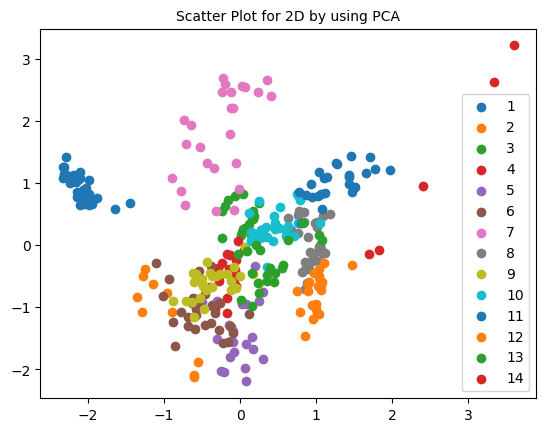

In [49]:
train_size = 0.1
X_train, y = data_scaled['X_train_' + str(train_size)], data_scaled['y_train_' + str(train_size)]
X1, X2 = X_train[:, 0], X_train[:, 1]

for class_name in range(1, 15):
    plt.scatter(X1[y == class_name], X2[y == class_name], label=class_name)
    
plt.title('Scatter Plot for 2D by using PCA', fontsize=10)
plt.legend()
plt.show()

- - <a name=''>${\text{Grid Search}}$</a>

In [36]:
data_reduced = data_scaled
input_data_dict = data_reduced

In [311]:
svc = SVC(random_state=0)

In [312]:
pipe = Pipeline(steps=[("svc", svc)])

In [313]:
param_grid = {'svc__C': np.logspace(-4, 4, 9), 'svc__kernel': ['linear', 'poly', 'rbf'], \
             'svc__gamma': np.linspace(0, 1, 11), 'svc__degree': [2, 3, 4]}

In [314]:
train_size = 0.1
best_k_fold = 15
X_train, y_train = input_data_dict['X_train_' + str(train_size)], input_data_dict['y_train_' + str(train_size)]
search = GridSearchCV(pipe, param_grid, cv=best_k_fold)
search.fit(X_train, y_train)

/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=15.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1215 fits failed out of a total of 13365.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1215 fits failed with the following error:
Traceback (most recent call last):
  File "/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/shahin/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, i

GridSearchCV(cv=15, estimator=Pipeline(steps=[('svc', SVC(random_state=0))]),
             param_grid={'svc__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'svc__degree': [2, 3, 4],
                         'svc__gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'svc__kernel': ['linear', 'poly', 'rbf']})

In [315]:
best_params = search.best_params_
best_lambda, best_gamma, best_kernel, best_degree = best_params['svc__C'], best_params['svc__gamma'], \
best_params['svc__kernel'], best_params['svc__degree']
print(f'\n\u03BB = {colored(best_lambda, "blue")}\n\n\u03B3 = \
{colored(best_gamma, "blue")}\n\nKernel = {colored(best_kernel, "blue")}\n\nDegree = \
{colored(best_degree, "blue")}\n')


λ = 1.0

γ = 0.1

Kernel = linear

Degree = 2



In [316]:
best_score = search.best_score_
print(f'\nBest Accuracy is: {colored(best_score, "green")}\n')


Best Accuracy is: 0.7867243867243867



- - <a name=''>${\text{Test:}}$</a>

In [317]:
train_size = 0.1
clf = SVC(C=best_lambda, kernel=best_kernel, degree=best_degree, gamma=best_gamma)
X_train, y_train, X_test, y_test = input_data_dict['X_train_' + str(train_size)], \
input_data_dict['y_train_' + str(train_size)], input_data_dict['X_test_' + str(train_size)], \
input_data_dict['y_test_' + str(train_size)]
clf.fit(X_train, y_train)

SVC(degree=2, gamma=0.1, kernel='linear')

In [318]:
y_pred = clf.predict(X_test)
ov_acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
acc_for_each_class = conf_mat.diagonal()/conf_mat.sum(axis=1)
df_result1 = pd.DataFrame({'Class': range(1, 15), 'Accuracy': acc_for_each_class})
df_result1

,Class,Accuracy
0,1,1.000000
1,2,0.923077
2,3,0.665217
3,4,0.723077
4,5,0.670732
5,6,0.733333
6,7,0.987179
7,8,0.723529
8,9,0.563380
9,10,0.731818


- <a name=''>${\bf{\text{Heatmap for Confusion Matrix}}}$</a>

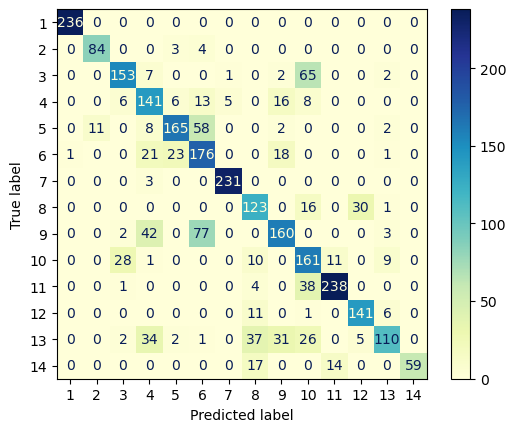

In [319]:
cmap_list = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', \
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',\
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=clf.classes_)
disp.plot(cmap=cmap_list[14])
plt.show()

In [320]:
print(f"\nResult of this Pipeline: {colored('Gaussian Noisy Input_Data', 'blue')} ---> \
{colored('Standard Scaler', 'magenta')}\
 ---> PCA ---> {colored('Standard Scaler', 'magenta')} ---> {colored('SVC', 'magenta')}")
print(f'\nOverall Accuracy: {colored(ov_acc, "green")}\n\n\u03BA = {colored(kappa, "green")}\n')


Result of this Pipeline: Gaussian Noisy Input_Data ---> Standard Scaler ---> PCA ---> Standard Scaler ---> SVC

Overall Accuracy: 0.7448700410396717

κ = 0.7238312797439801

